# Defect Prediction on production lines by VALEO
## Challenge context
Valeo is a French global automotive supplier headquartered in France, listed on the Paris Stock Exchange (CAC-40 Index). It supplies a wide range of products to automakers and the aftermarket. The Group employs 113,600 people in 33 countries worldwide. It has 186 production plants, 59 R&D centers and 15 distribution platforms. Its strategy is focused on innovation and development in high-growth potential regions and emerging countries. Valeo ranked as France's leading patent filer from 2016 to 2018.
 
## Challenge goals
The goal of the challenge is to predict defect on starter motor production lines. During production samples assembly, different values (torques, angles ...) are measured on different mounting stations. At the end of the line, additional measures are performed on two test benches in order to isolate defects. As a result, samples are tagged ‘OK’, ‘KO’. We would like to design a model that could identify such defects before the test bench step.

## Data description
**ID** = PROC_TRACEINFO = it’s a unique code given to the product. Example : I-B-XA1207672-190701-00494.

XA1207672 is the reference.
190701 is the date: here 01st of July of year 2019.
00494 is the unique code given to the product, whatever it happens, the product will have this id number frozen forever.
This number is increased by 1 each time we process a new product, every 12s. So for example : I-B-XA1207672-190701-00495 is the next product.

**Inputs** : Input features are measures collected on different assembly stations with the sensors or devices connected to Programmable Logic Controllers which are storing all of them to keep the full quality traceability. (Examples : OP070_V_1_angle_value, OP120_Rodage_I_value, etc…).

**Output** : This is the result value of OP130 (test bench). Value 0 is assigned to OK samples (passed) and value 1 is assigned to KO samples (failed). This is the combined result of multiple electrical, acoustic and vibro-acoustic tests.

**The target** is to find the best prediction : Output = f (inputs). The dataset contains 34515 training samples and 8001 test samples.

***

# 2. Data Pre-processing

In [1]:
from IPython.core.interactiveshell import InteractiveShell 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
nb_path = os.path.abspath(".")

In [2]:
nb_path = os.path.abspath(".")
InteractiveShell.ast_node_interactivity = "all"
sns.set(color_codes=True)

In [3]:
X_validation = pd.read_csv(os.path.join(nb_path,"testinputs.csv")) 
dataset = pd.read_csv(os.path.join(nb_path,"traininginputs.csv")).merge(pd.read_csv(os.path.join(nb_path,"trainingoutput.csv")), on="PROC_TRACEINFO")

In [4]:
target = "Binar OP130_Resultat_Global_v"
code = "PROC_TRACEINFO"
capuchon_measure = "OP100_Capuchon_insertion_mesure"
selected_measures = ['OP070_V_1_angle_value','OP090_SnapRingPeakForce_value', 'OP090_SnapRingFinalStroke_value','OP070_V_1_torque_value','OP090_SnapRingMidPointForce_val', 'OP070_V_2_torque_value']

In [5]:
dataset

,PROC_TRACEINFO,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value,Binar OP130_Resultat_Global_v
0,I-B-XA1207672-190429-00688,180.4,190.51,173.1,113.64,12.04,12.16,NaN,11.97,6.62,26.37,18.8,109.62,6.60,0
1,I-B-XA1207672-190828-00973,138.7,147.70,163.5,109.77,12.12,12.19,0.39,11.97,6.41,21.03,18.5,105.48,6.40,0
2,I-B-XA1207672-190712-03462,180.9,150.87,181.2,109.79,11.86,12.24,NaN,11.97,6.62,25.81,17.5,100.03,6.61,0
3,I-B-XA1207672-190803-00051,173.5,159.56,151.8,113.25,11.82,12.35,0.39,11.97,6.62,24.62,15.6,104.94,6.61,0
4,I-B-XA1207672-190508-03248,174.5,172.29,177.5,112.88,12.07,12.19,NaN,11.97,6.62,29.22,33.6,99.19,6.61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34510,I-B-XA1207672-190520-00031,158.2,168.40,180.6,110.65,11.88,12.23,NaN,11.98,6.61,24.03,14.8,98.76,6.61,0
34511,I-B-XA1207672-190906-00270,139.4,146.24,154.5,108.14,12.04,12.27,0.41,11.97,6.41,21.52,15.5,98.37,6.40,0
34512,I-B-XA1207672-190429-00930,165.5,157.34,149.8,112.77,12.09,12.17,NaN,11.97,6.62,22.65,24.4,92.92,6.62,0
34513,I-B-XA1207672-190424-02120,152.4,165.07,140.0,111.19,12.06,12.34,NaN,11.97,6.60,20.77,13.6,101.21,6.60,0


## Data Splitting

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
trainset, testset = train_test_split(dataset, test_size=0.2, random_state=0)

## Pre-processing Steps

In [34]:
def imputation(df):
    
    df = df.drop(["OP100_Capuchon_insertion_mesure", "OP120_Rodage_U_mesure_value"], axis=1)
    
    return df

In [37]:
def preprocessing(df):
    df = imputation(df) 
# df = feature_engineering(df)
# df = outliers_removing(df)
    X = df.drop([target,code], axis=1)
    y = df[target]
    
    print(y.value_counts())
    
    return X, y

In [38]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

0    27374
1      238
Name: Binar OP130_Resultat_Global_v, dtype: int64
0    6836
1      67
Name: Binar OP130_Resultat_Global_v, dtype: int64


In [39]:
X_train.head()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value
20907,146.8,157.47,142.3,115.35,12.09,12.40,6.41,21.09,12.5,95.90,6.42
26482,146.8,178.43,154.9,117.87,12.08,12.29,6.62,25.28,14.5,97.66,6.61
22105,156.3,149.65,158.3,109.18,12.12,12.16,6.41,17.80,16.0,81.39,6.41
25164,183.5,181.87,157.2,115.00,12.07,12.18,6.60,23.89,18.9,100.32,6.60
991,161.7,164.63,157.4,111.54,12.08,12.24,6.62,19.67,22.5,105.25,6.61


In [40]:
y_train.head()

20907    0
26482    0
22105    0
25164    0
991      0
Name: Binar OP130_Resultat_Global_v, dtype: int64

# 3. Model Building

## Evaluation procedure

In [20]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve

In [21]:
def evaluation(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(roc_auc_score(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
#     print(classification_report_imbalanced(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                          cv=4, scoring='roc_auc',
                                               train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

## Model Selection

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [16]:
RandomForest = make_pipeline(RandomUnderSampler(random_state=0) , PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10), RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(RandomUnderSampler(random_state=0) , PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10), AdaBoostClassifier(random_state=0))
SVM = make_pipeline(RandomUnderSampler(random_state=0) , PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10), StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(RandomUnderSampler(random_state=0) , PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10), StandardScaler(), KNeighborsClassifier())

In [17]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
0.534599530143315
[[3738 3098]
 [  32   35]]
              precision    recall  f1-score   support

           0       0.99      0.55      0.70      6836
           1       0.01      0.52      0.02        67

    accuracy                           0.55      6903
   macro avg       0.50      0.53      0.36      6903
weighted avg       0.98      0.55      0.70      6903

AdaBoost
0.6101706942176188
[[4057 2779]
 [  25   42]]
              precision    recall  f1-score   support

           0       0.99      0.59      0.74      6836
           1       0.01      0.63      0.03        67

    accuracy                           0.59      6903
   macro avg       0.50      0.61      0.39      6903
weighted avg       0.98      0.59      0.74      6903

SVM
0.5861582229286569
[[4749 2087]
 [  35   32]]
              precision    recall  f1-score   support

           0       0.99      0.69      0.82      6836
           1       0.02      0.48      0.03        67

    accuracy       

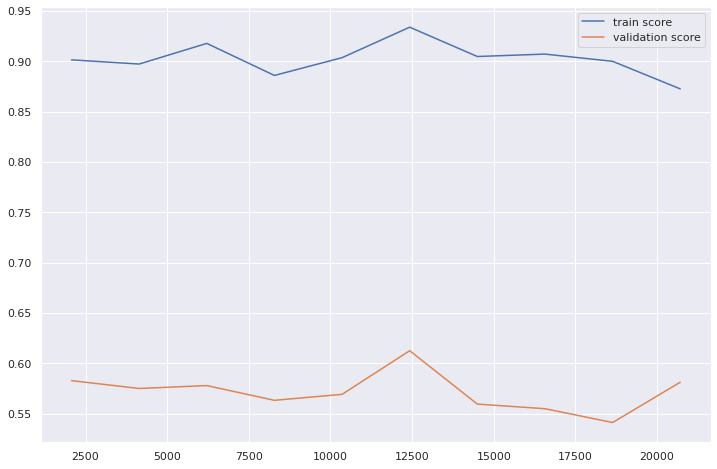

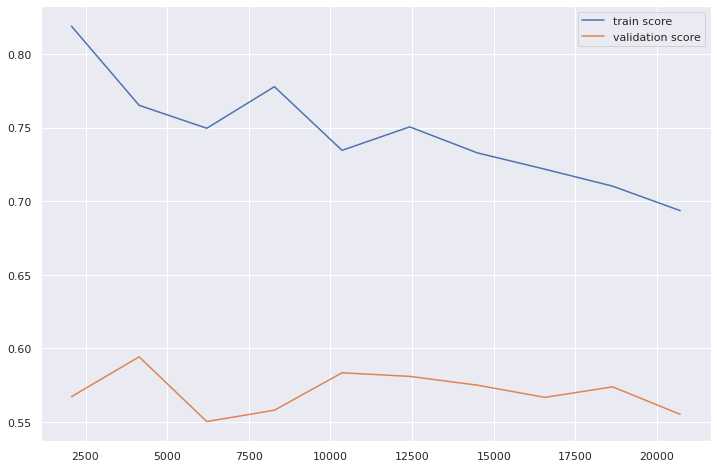

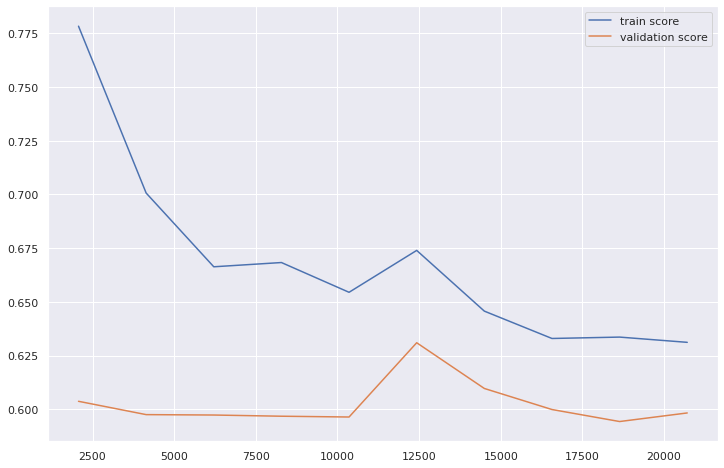

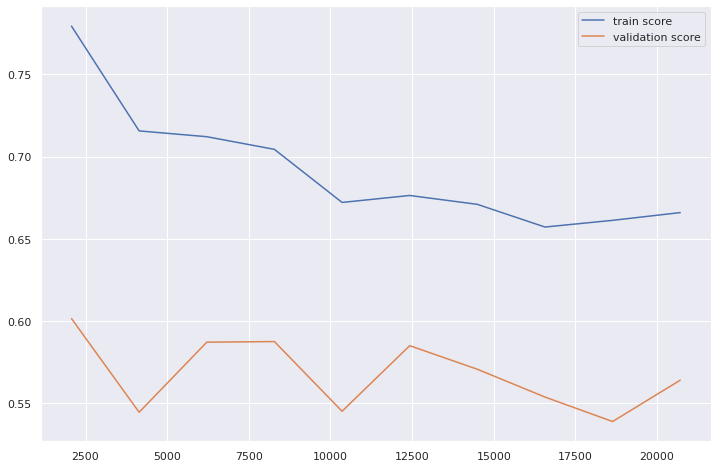

In [22]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

## Hyperparameter Tuning

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SMOTENC, SVMSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [ ]:
# best performer: auc=0.6609422897216668
# prepro: drop capuchon
# model = make_pipeline(RandomUnderSampler(random_state=0), SelectKBest(f_classif, k=7), LogisticRegression(random_state=0))

# 2nd performer: auc: 0.6406688034374645
# prepro:drop capuchon
# better training score than LR
# model = make_pipeline(RandomUnderSampler(sampling_strategy=1,random_state=0), StandardScaler(), SelectKBest(f_classif, k=10), SVC(random_state=0, kernel='rbf'))

XGB = make_pipeline(SelectKBest(f_classif, k="all"), XGBClassifier(random_state=0, n_jobs=-1, scale_pos_weight=100))
                                                                                                                                               

# model = make_pipeline(RandomUnderSampler(random_state=0), RobustScaler(), SelectKBest(f_classif, k=9), BaggingClassifier(base_estimator=SVC(random_state=0), n_estimators=100, n_jobs=-1))

# SVM = make_pipeline(RandomUnderSampler(random_state=0), StandardScaler(), SelectKBest(f_classif), SVC(random_state=0))
# LR = make_pipeline(RandomUnderSampler(random_state=0), StandardScaler(), SelectKBest(f_classif), LogisticRegression(random_state=0, n_jobs=-1))
# NB = make_pipeline(preprocessor, GaussianNB())
# RF = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))

# model = make_pipeline(SMOTETomek(random_state=0, n_jobs=-1), StandardScaler(), SelectKBest(f_classif, k=10), SVC(random_state=0, kernel='rbf'))
# model = make_pipeline(RandomUnderSampler(random_state=0), SelectKBest(f_classif, k=9), RandomForestClassifier(random_state=0))
# model = make_pipeline(RandomUnderSampler(random_state=0), PolynomialFeatures(), SelectKBest(f_classif, k='all'), RandomForestClassifier(random_state=0))
# model = make_pipeline(RandomUnderSampler(random_state=0), PolynomialFeatures(), PCA(n_components=10, random_state=0), RandomForestClassifier(random_state=0))
# model = make_pipeline(RandomUnderSampler(random_state=0), StandardScaler(), SelectKBest(f_classif, k=9), XGBClassifier())
# model = make_pipeline(SMOTE(random_state=0, n_jobs=-1), RandomForestClassifier(random_state=0))
# model = DecisionTreeClassifier(random_state=0)
# model = RandomForestClassifier(random_state=0)

In [ ]:
evaluation(model)
# evaluation(grid.best_estimator_)

<AxesSubplot:>

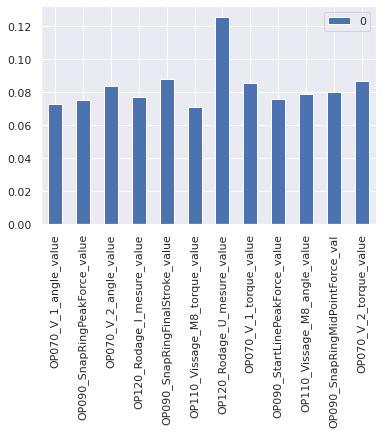

In [70]:
# pd.DataFrame(model.feature_importances_, index=X_train.columns).plot.bar()
pd.DataFrame(model.named_steps["xgbclassifier"].feature_importances_, index=X_train.columns).plot.bar()

## Hyperparameter Tuning

In [27]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [45]:
param_test1 = {
     'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)

}

param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

param_test7 = {
    'learning_rate' : [0.01],
    'n_estimators' : [50,100,200]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier( random_state=0, learning_rate =0.01, n_estimators=100, max_depth=2,
 min_child_weight=1.5, gamma=0.3, subsample=0.6, colsample_bytree=0.9,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=100, seed=27, reg_alpha=0.01), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=-1,iid=False, cv=5)

gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

/home/sckobayashi/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.9, gamma=0.3,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_delta_step=None,
                                     max_depth=2, min_child_weight=1.5,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=95, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=0.01, reg_lambda=None,
                                     scale_pos_weight=100, seed=27,
                                     subsample=0.6, tree_meth

({'learning_rate': 0.01, 'n_estimators': 100}, 0.6534636022653416)

<AxesSubplot:>

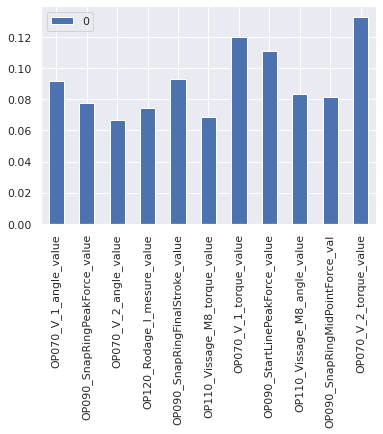

In [46]:
pd.DataFrame(gsearch1.best_estimator_.feature_importances_, index=X_train.columns).plot.bar()

0.5974821620394225
[[5516 1320]
 [  41   26]]
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      6836
           1       0.02      0.39      0.04        67

    accuracy                           0.80      6903
   macro avg       0.51      0.60      0.46      6903
weighted avg       0.98      0.80      0.88      6903



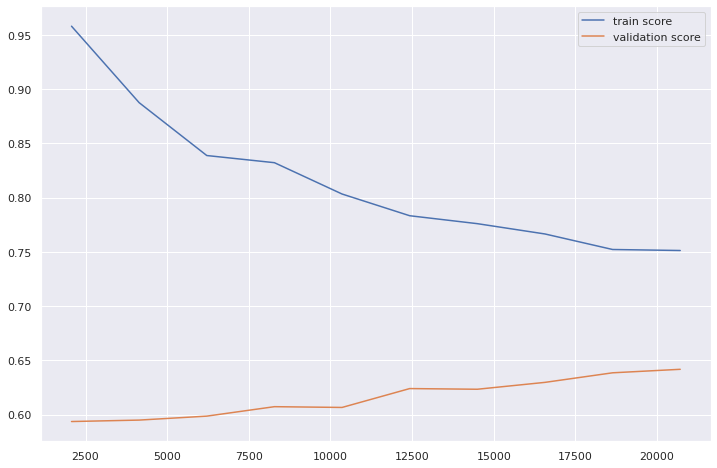

In [52]:
evaluation(gsearch1.best_estimator_)

# Test set prediction

In [47]:
model_final = gsearch1.best_estimator_
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_validation.drop([code,"OP100_Capuchon_insertion_mesure","OP120_Rodage_U_mesure_value"], axis=1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=2,
              min_child_weight=1.5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0.01, reg_lambda=1,
              scale_pos_weight=100, seed=27, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [48]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [49]:
df_submission = X_validation[[code]]
df_submission.insert(loc=1, column=target, value= y_pred)

In [50]:
df_submission

,PROC_TRACEINFO,Binar OP130_Resultat_Global_v
0,I-B-XA1207672-190520-00632,0
1,I-B-XA1207672-190508-03689,0
2,I-B-XA1207672-190715-00577,0
3,I-B-XA1207672-190503-00796,0
4,I-B-XA1207672-190712-01837,0
...,...,...
7996,I-B-XA1207672-190905-03031,1
7997,I-B-XA1207672-190531-00225,0
7998,I-B-XA1207672-190424-03040,0
7999,I-B-XA1207672-190715-00155,0


In [51]:
df_submission.set_index(code).to_csv('submission_xgboost.csv')